<a href="https://colab.research.google.com/github/nitish-pandey/Movie-Recommendation-System/blob/main/User_Likings_and_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import ast

#Data Loading and preparing

In [2]:
ratings=pd.read_csv('/Datasets/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556


In [3]:
meta=pd.read_csv('/Datasets/final_metadata.csv')
meta.head()

,adult,genres,id,imdb_id,original_language,overview,release_date,runtime,tagline,title
0,False,Animation Comedy Family,862,tt0114709,en,"Led by Woody, Andy's toys live happily in his ...",1995-10-30,81.0,NaN,Toy Story
1,False,Adventure Fantasy Family,8844,tt0113497,en,When siblings Judy and Peter discover an encha...,1995-12-15,104.0,Roll the dice and unleash the excitement!,Jumanji
2,False,Romance Comedy,15602,tt0113228,en,A family wedding reignites the ancient feud be...,1995-12-22,101.0,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men
3,False,Comedy Drama Romance,31357,tt0114885,en,"Cheated on, mistreated and stepped on, the wom...",1995-12-22,127.0,Friends are the people who let you be yourself...,Waiting to Exhale
4,False,Comedy,11862,tt0113041,en,Just when George Banks has recovered from his ...,1995-02-10,106.0,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II


In [4]:
meta=meta[['genres','id']]
meta.head()

,genres,id
0,Animation Comedy Family,862
1,Adventure Fantasy Family,8844
2,Romance Comedy,15602
3,Comedy Drama Romance,31357
4,Comedy,11862


In [5]:
ratings.rename(columns={'movieId':'id'},inplace=True)
ratings.drop(['timestamp'],axis=1,inplace=True)
ratings['id']=ratings['id'].astype(str)
ratings.head()

,userId,id,rating
0,1,110,1.0
1,1,147,4.5
2,1,858,5.0
3,1,1221,5.0
4,1,1246,5.0


In [6]:
merged=pd.merge(ratings,meta,on='id',how='left')
merged.head()

,userId,id,rating,genres
0,1,110,1.0,Drama Mystery Romance
1,1,147,4.5,Drama
2,1,858,5.0,Comedy Drama Romance
3,1,1221,5.0,NaN
4,1,1246,5.0,Drama


In [7]:
merged=merged.dropna(subset={'genres'})

# Creating the user likings

We create the dataframe that consist of each user id and the average ratings of this user in each genres in respective column .
This dataframe will give the likings or the field ( or degree of intrest ) in the respective column.

In [9]:
merged['genres']=merged['genres'].str.split()
merged.head()

,userId,id,rating,genres
0,1,110,1.0,"[Drama, Mystery, Romance]"
1,1,147,4.5,[Drama]
2,1,858,5.0,"[Comedy, Drama, Romance]"
4,1,1246,5.0,[Drama]
5,1,1968,4.0,"[Drama, Comedy, Romance]"


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


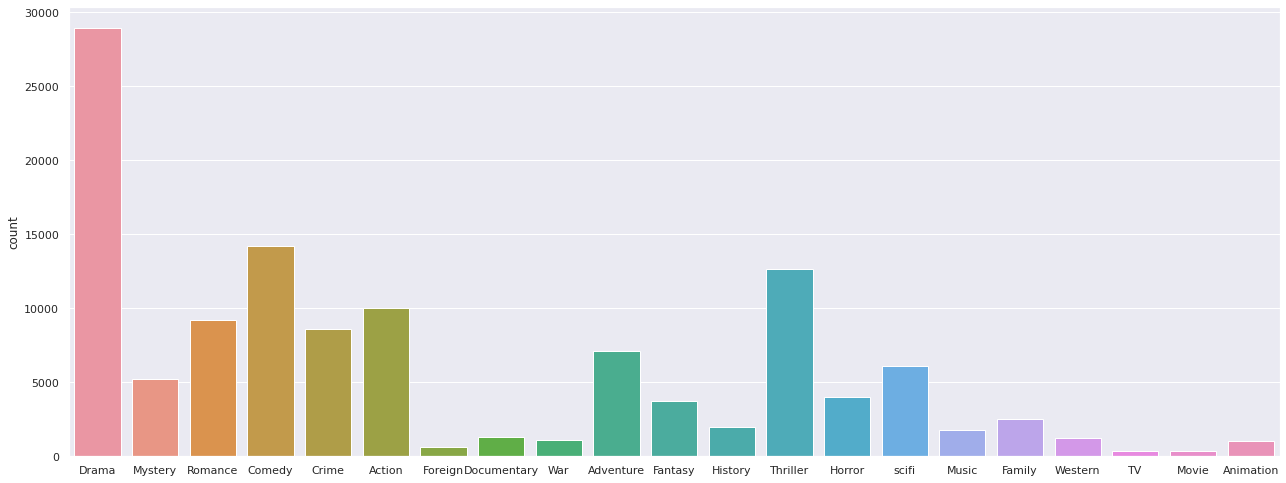

In [10]:
genres=[]
for i in merged['genres']:
    for x in i:
        genres.append(x)

sns.set(rc={'figure.figsize':(21.7,8.27)})
sns.countplot(genres)

In [11]:
likings = merged.explode('genres').pivot_table(index='userId', columns='genres', values='rating', aggfunc='mean').fillna(0, downcast='infer')
likings.head()

genres,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,...,Horror,Movie,Music,Mystery,Romance,TV,Thriller,War,Western,scifi
userId,,,,,,,,,,,,,,,,,,,,,
1,3.500000,0.0,0.0,4.25,4.500000,5.0,4.125000,0.0,0.00,3.5,...,0.0,0.0,0.0,1.0,3.333333,0.0,0.000000,0.0,0.0,0.000000
2,3.750000,3.5,0.0,2.80,3.000000,0.0,3.000000,1.5,3.25,0.0,...,4.0,0.0,1.0,3.5,4.000000,0.0,4.000000,3.0,0.0,4.000000
3,3.000000,0.0,0.0,3.20,2.666667,0.0,3.400000,0.0,3.00,0.0,...,0.0,0.0,0.0,3.0,3.333333,0.0,2.500000,0.0,0.0,3.000000
4,3.500000,4.0,0.0,3.00,4.250000,4.0,3.727273,0.0,4.00,1.0,...,4.0,0.0,0.0,3.5,3.166667,0.0,3.666667,0.0,5.0,4.000000
5,2.666667,2.0,0.0,5.00,5.000000,0.0,4.500000,0.0,0.00,0.0,...,5.0,0.0,0.0,5.0,5.000000,0.0,3.250000,0.0,4.0,3.666667


# Generating the similarity between the users using Cosine-similarity

In [12]:
from sklearn.metrics.pairwise import cosine_similarity

cosine=cosine_similarity(likings)

cosine_user=pd.DataFrame(cosine,index=likings.index,columns=likings.index)

cosine_user.iloc[:10,:10]

userId,1,2,3,4,5,6,7,8,9,10
userId,,,,,,,,,,
1,1.000000,0.489903,0.654896,0.642842,0.615778,0.426867,0.636767,0.409454,0.499017,0.562556
2,0.489903,1.000000,0.810509,0.806928,0.807459,0.671542,0.710828,0.853232,0.891625,0.877986
3,0.654896,0.810509,1.000000,0.776454,0.813698,0.718298,0.624877,0.606167,0.796765,0.792287
4,0.642842,0.806928,0.776454,1.000000,0.870309,0.624815,0.795418,0.730201,0.800911,0.799698
5,0.615778,0.807459,0.813698,0.870309,1.000000,0.539157,0.764210,0.673643,0.744976,0.890220
6,0.426867,0.671542,0.718298,0.624815,0.539157,1.000000,0.530228,0.545319,0.657278,0.581401
7,0.636767,0.710828,0.624877,0.795418,0.764210,0.530228,1.000000,0.750339,0.694264,0.688607
8,0.409454,0.853232,0.606167,0.730201,0.673643,0.545319,0.750339,1.000000,0.840630,0.679531
9,0.499017,0.891625,0.796765,0.800911,0.744976,0.657278,0.694264,0.840630,1.000000,0.808858


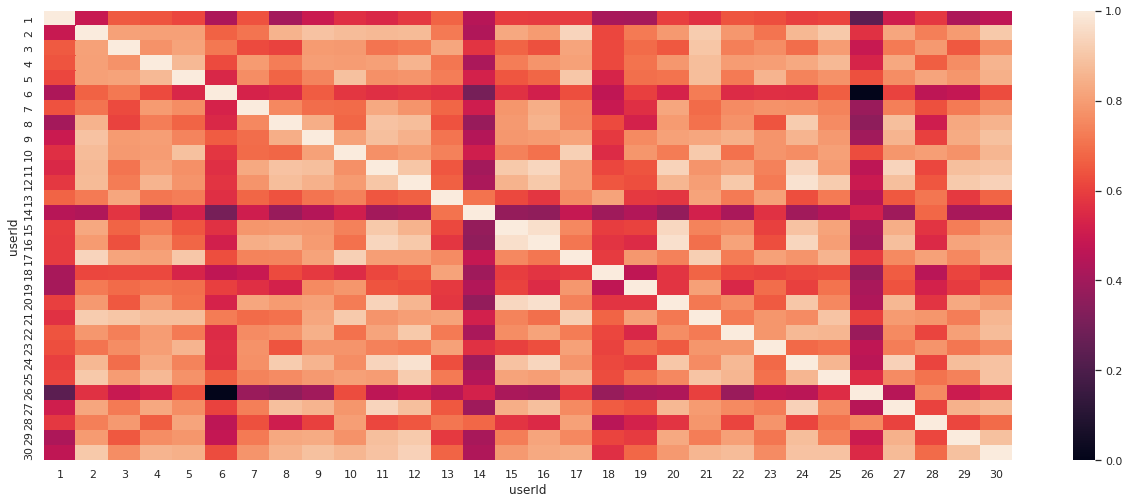

In [13]:

sns.heatmap(cosine_user.iloc[:30,:30])

# Creating the clusters of users using K-Means

In [14]:
from sklearn.cluster import KMeans

cluster=KMeans()
cluster.fit(likings)

KMeans()

In [15]:
cluster.labels_

array([7, 3, 7, ..., 1, 3, 6], dtype=int32)

In [16]:
likings['cluster']=''

for i in range(len(likings)):
    likings['cluster'][i]=cluster.labels_[i]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [17]:
likings['cluster'].head(10)

userId
1     3
2     7
3     2
4     2
5     4
6     5
7     1
8     3
9     0
10    1
Name: cluster, dtype: object

In [18]:
likings.to_csv('user_likings.csv')
cosine_user.to_csv("user_similarity.csv")